In [1]:
from IPython.core.display import display, HTML

import pandas as pd
import numpy as np # linear algebra
import glob
import os
import gc

from joblib import Parallel, delayed

from sklearn import preprocessing, model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt 
import seaborn as sns
import numpy.matlib


path_submissions = '/'

target_name = 'target'
scores_folds = {}

In [2]:
# data directory
data_dir = '../input/optiver-realized-volatility-prediction/'

# Function to calculate first WAP
def calc_wap1(df):
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap

# Function to calculate second WAP
def calc_wap2(df):
    wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

def calc_wap3(df):
    wap = (df['bid_price1'] * df['bid_size1'] + df['ask_price1'] * df['ask_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap

def calc_wap4(df):
    wap = (df['bid_price2'] * df['bid_size2'] + df['ask_price2'] * df['ask_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

def calc_waph1(df):
    wap1_mean = df['wap1'].mean()
    waph1 = df['wap1'].apply(lambda x:x-wap1_mean)
    return waph1
    
def calc_waph2(df):
    wap2_mean = df['wap2'].mean()
    waph2 = df['wap2'].apply(lambda x:x-wap2_mean)
    return waph2
    
def calc_waph3(df):
    wap3_mean = df['wap3'].mean()
    waph3 = df['wap3'].apply(lambda x:x-wap3_mean)
    return waph3
    
def calc_waph4(df):
    wap4_mean = df['wap4'].mean()
    waph4 = df['wap4'].apply(lambda x:x-wap4_mean)
    return waph4

def log_return(series):
    return np.log(series).diff()

def realized_volatility(series):
    return np.sqrt(np.sum(series**2))

def historical_volatility(series):
    return np.sqrt(np.sum(series**2)/len(series))

def count_unique(series):
    return len(np.unique(series))

def encode_mean(column, df):
    avg = df.groupby('time_id')[column].transform('mean')
    return np.abs(df[column].sub(avg).div(avg))

def pressure_compute1(df):
    df['mid_price1'] = (df['bid_price1'] + df['ask_price1'])/2
    sell_percent_with_mid_price1 = df["mid_price1"]/(df["mid_price1"]-df['ask_price1'])
    sell_percent_with_mid_price2 = df["mid_price1"]/(df["mid_price1"]-df['ask_price2'])
    buy_percent_with_mid_price1 = df["mid_price1"]/(df["mid_price1"]-df['bid_price1'])
    buy_percent_with_mid_price2 = df["mid_price1"]/(df["mid_price1"]-df['bid_price2'])
    sell_pressure = sell_percent_with_mid_price1/sell_percent_with_mid_price1.sum()*df['ask_size1']+ \
    sell_percent_with_mid_price2/sell_percent_with_mid_price2.sum()*df['ask_size2']
    buy_pressure = buy_percent_with_mid_price1/buy_percent_with_mid_price1.sum()*df['bid_size1']+ \
    buy_percent_with_mid_price2/buy_percent_with_mid_price2.sum()*df['bid_size2']
    pressure_ratio = np.log(buy_pressure) - np.log(sell_pressure)
    return pressure_ratio

def pressure_compute2(df):
    df['mid_price2'] = (df['bid_price2'] + df['ask_price2'])/2
    sell_percent_with_mid_price1 = df["mid_price2"]/(df["mid_price2"]-df['ask_price1'])
    sell_percent_with_mid_price2 = df["mid_price2"]/(df["mid_price2"]-df['ask_price2'])
    buy_percent_with_mid_price1 = df["mid_price2"]/(df["mid_price2"]-df['bid_price1'])
    buy_percent_with_mid_price2 = df["mid_price2"]/(df["mid_price2"]-df['bid_price2'])
    sell_pressure = sell_percent_with_mid_price1/sell_percent_with_mid_price1.sum()*df['ask_size1']+ \
    sell_percent_with_mid_price2/sell_percent_with_mid_price2.sum()*df['ask_size2']
    buy_pressure = buy_percent_with_mid_price1/buy_percent_with_mid_price1.sum()*df['bid_size1']+ \
    buy_percent_with_mid_price2/buy_percent_with_mid_price2.sum()*df['bid_size2']
    pressure_ratio = np.log(buy_pressure) - np.log(sell_pressure)
    return pressure_ratio

def read_train_test():
    train = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
    test = pd.read_csv('../input/optiver-realized-volatility-prediction/test.csv')
    # Create a key to merge with book and trade data
    train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
    test['row_id'] = test['stock_id'].astype(str) + '-' + test['time_id'].astype(str)
    print(f'Our training set has {train.shape[0]} rows')
    return train,test

def book_preprocessor(file_path):
    df = pd.read_parquet(file_path)
    
    # Calculate Wap
    df['wap1'] = calc_wap1(df)
    df['wap2'] = calc_wap2(df)
    df['wap3'] = calc_wap3(df)
    df['wap4'] = calc_wap4(df)
    #df['waph1'] = calc_waph1(df)
    #df['waph2'] = calc_waph2(df)
    #df['waph3'] = calc_waph3(df)
    #df['waph4'] = calc_waph4(df)
    #df['relative_wap_balance1'] = (df['wap1'] - df['wap2'])/( df['wap1'] + df['wap2'])
    #df["relative_wap_balance2"] = (df['wap3'] - df['wap4'])/( df['wap3'] + df['wap4'])
    
    # Calculate log returns
    df['log_return1'] = df.groupby(['time_id'])['wap1'].apply(log_return)
    df['log_return2'] = df.groupby(['time_id'])['wap2'].apply(log_return)
    df['log_return3'] = df.groupby(['time_id'])['wap3'].apply(log_return)
    df['log_return4'] = df.groupby(['time_id'])['wap4'].apply(log_return)
    
    # Calculate wap balance
    df['wap_balance'] = abs(df['wap1'] - df['wap2'])
    #df['wap_balance2'] = abs(df['wap3'] - df['wap4'])

    
    # Calculate spread
    df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1']) / 2)
    df['price_spread2'] = (df['ask_price2'] - df['bid_price2']) / ((df['ask_price2'] + df['bid_price2']) / 2)
    df['bid_spread'] = df['bid_price1'] - df['bid_price2']
    df['ask_spread'] = df['ask_price1'] - df['ask_price2']
    df["bid_ask_spread"] = abs(df['bid_spread'] - df['ask_spread'])
    df['bid_ask_spread1'] = abs(df['bid_price1'] - df['ask_price1']) # Spread가 좁을수록 판매가 easy -> 거래가 많아짐
    df['bid_ask_spread2'] = abs(df['bid_price2'] - df['ask_price2'])
    df['total_volume'] = (df['ask_size1'] + df['ask_size2']) + (df['bid_size1'] + df['bid_size2'])
    df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))
    
    #df['pressure_ratio1'] = pressure_compute1(df)
    #df['pressure_ratio2'] = pressure_compute2(df)
    
    #Calculate Volume imbalance 
    #df['depth_imbalance1'] = (df['ask_size1'] - df["bid_size1"])/(df['ask_size1'] + df["bid_size1"])
    #df['depth_imbalance2'] = (df['ask_size2'] - df["bid_size2"])/(df['ask_size2'] + df["bid_size2"])
    
    def premad(x):
        return np.median(np.absolute(x-np.median(x,axis=0)),axis=0)
    
    def iqr_func5(x):
        low = 5
        high = 95
        q3, q1 = np.percentile(x, [low, high])
        iqr = q3 - q1
        return iqr
    
    def iqr_func25(x):
        low = 25
        high = 75
        q3, q1 = np.percentile(x, [low, high])
        iqr = q3 - q1
        return iqr
    
    def iqr_func15(x):
        low = 15
        high = 85
        q3, q1 = np.percentile(x, [low, high])
        iqr = q3 - q1
        return iqr
    
    def iqr_func5(x):
        low = 5
        high = 95
        q3, q1 = np.percentile(x, [low, high])
        iqr = q3 - q1
        return iqr

    def preskew(x):
        return skew(x)

    def prekurt(x):
        return kurtosis(x,fisher=True)
    
    # Dict for aggregations
    create_feature_dict = {
        'bid_price1':['max','min','last','first'],
        'bid_price2':['max','min','last','first'],
        'ask_price1':['max','min','last','first'],
        'ask_price2':['max','min','last','first'],
        'wap1': [np.sum, np.std],
        'wap2': [np.sum, np.std],
        'wap3': [np.sum, np.std],
        'wap4': [np.sum, np.std],
        #'waph1':[np.sum, np.std],
        #'waph2':[np.sum, np.std],
        #'waph3':[np.sum, np.std],
        #'waph4':[np.sum, np.std],
        #'relative_wap_balance1':[np.sum, np.max],
        #'depth_imbalance1':[np.sum, np.max],
        'log_return1': [realized_volatility],
        'log_return2': [realized_volatility],
        'log_return3': [realized_volatility],
        'log_return4': [realized_volatility],
        'wap_balance': [np.sum, np.max],
        'price_spread':[np.sum, np.max],
        'price_spread2':[np.sum, np.max],
        'bid_spread':[np.sum, np.max],
        'ask_spread':[np.sum, np.max],
        'total_volume':[np.sum, np.max],
        'volume_imbalance':[np.sum, np.max],
        "bid_ask_spread":[np.sum,  np.max],
    }
    create_feature_dict_time = {
        'log_return1': [realized_volatility],
        'log_return2': [realized_volatility],
        'log_return3': [realized_volatility],
        'log_return4': [realized_volatility],
        #'bid_price1':['max','min','last','first'],
        #'bid_price2':['max','min','last','first'],
        #'ask_price1':['max','min','last','first'],
        #'ask_price2':['max','min','last','first'],
    }
    
    # Function to get group stats for different windows (seconds in bucket)
    def get_stats_window(fe_dict,seconds_in_bucket, add_suffix = False):
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(fe_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature
    
    # Get the stats for different windows
    df_feature = get_stats_window(create_feature_dict,seconds_in_bucket = 0, add_suffix = False)
    df_feature_500 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 500, add_suffix = True)
    df_feature_400 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 400, add_suffix = True)
    df_feature_300 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 300, add_suffix = True)
    df_feature_200 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 200, add_suffix = True)
    df_feature_100 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 100, add_suffix = True)

    # Merge all
    df_feature = df_feature.merge(df_feature_500, how = 'left', left_on = 'time_id_', right_on = 'time_id__500')
    df_feature = df_feature.merge(df_feature_400, how = 'left', left_on = 'time_id_', right_on = 'time_id__400')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_200, how = 'left', left_on = 'time_id_', right_on = 'time_id__200')
    df_feature = df_feature.merge(df_feature_100, how = 'left', left_on = 'time_id_', right_on = 'time_id__100')
    # Drop unnecesary time_ids
    df_feature.drop(['time_id__500','time_id__400', 'time_id__300', 'time_id__200','time_id__100'], axis = 1, inplace = True)
    
    
    # Create row_id so we can merge
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['time_id_'].apply(lambda x: f'{stock_id}-{x}')
    df_feature.drop(['time_id_'], axis = 1, inplace = True)
    return df_feature

# Function to preprocess trade data (for each stock id)
def trade_preprocessor(file_path):
    df = pd.read_parquet(file_path)
    df['log_return'] = df.groupby('time_id')['price'].apply(log_return)
    df['amount']=df['price']*df['size']
    # Dict for aggregations
    create_feature_dict = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum, np.max, np.min],
        'order_count':[np.sum,np.max],
        'amount':[np.sum,np.max,np.min],
        'price':['max','min','last','first'],
    }
    create_feature_dict_time = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum],
        'order_count':[np.sum],
        'price':['max','min','last','first'],
    }
    # Function to get group stats for different windows (seconds in bucket)
    def get_stats_window(fe_dict,seconds_in_bucket, add_suffix = False):
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(fe_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature
    

    # Get the stats for different windows
    df_feature = get_stats_window(create_feature_dict,seconds_in_bucket = 0, add_suffix = False)
    df_feature_500 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 500, add_suffix = True)
    df_feature_400 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 400, add_suffix = True)
    df_feature_300 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 300, add_suffix = True)
    df_feature_200 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 200, add_suffix = True)
    df_feature_100 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 100, add_suffix = True)
    
    def tendency(price, vol):    
        df_diff = np.diff(price)
        val = (df_diff/price[1:])*100
        power = np.sum(val*vol[1:])
        return(power)
    
    lis = []
    for n_time_id in df['time_id'].unique():
        df_id = df[df['time_id'] == n_time_id]        
        tendencyV = tendency(df_id['price'].values, df_id['size'].values)      
        f_max = np.sum(df_id['price'].values > np.mean(df_id['price'].values))
        f_min = np.sum(df_id['price'].values < np.mean(df_id['price'].values))
        df_max =  np.sum(np.diff(df_id['price'].values) > 0)
        df_min =  np.sum(np.diff(df_id['price'].values) < 0)
        # new
        abs_diff = np.median(np.abs( df_id['price'].values - np.mean(df_id['price'].values)))        
        energy = np.mean(df_id['price'].values**2)
        iqr_p = np.percentile(df_id['price'].values,75) - np.percentile(df_id['price'].values,25)
        
        # vol vars
        
        abs_diff_v = np.median(np.abs( df_id['size'].values - np.mean(df_id['size'].values)))        
        energy_v = np.sum(df_id['size'].values**2)
        iqr_p_v = np.percentile(df_id['size'].values,75) - np.percentile(df_id['size'].values,25)
        
        lis.append({'time_id':n_time_id,'tendency':tendencyV,'f_max':f_max,'f_min':f_min,'df_max':df_max,'df_min':df_min,
                   'abs_diff':abs_diff,'energy':energy,'iqr_p':iqr_p,'abs_diff_v':abs_diff_v,'energy_v':energy_v,'iqr_p_v':iqr_p_v})
    
    df_lr = pd.DataFrame(lis)
        
   
    df_feature = df_feature.merge(df_lr, how = 'left', left_on = 'time_id_', right_on = 'time_id')
    
    # Merge all
    df_feature = df_feature.merge(df_feature_500, how = 'left', left_on = 'time_id_', right_on = 'time_id__500')
    df_feature = df_feature.merge(df_feature_400, how = 'left', left_on = 'time_id_', right_on = 'time_id__400')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_200, how = 'left', left_on = 'time_id_', right_on = 'time_id__200')
    df_feature = df_feature.merge(df_feature_100, how = 'left', left_on = 'time_id_', right_on = 'time_id__100')
    # Drop unnecesary time_ids
    df_feature.drop(['time_id__500','time_id__400', 'time_id__300', 'time_id__200','time_id','time_id__100'], axis = 1, inplace = True)
    
    
    df_feature = df_feature.add_prefix('trade_')
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['trade_time_id_'].apply(lambda x:f'{stock_id}-{x}')
    df_feature.drop(['trade_time_id_'], axis = 1, inplace = True)
    return df_feature

# Function to get group stats for the stock_id and time_id
def get_time_stock(df):
    vol_cols = ['log_return1_realized_volatility', 'log_return2_realized_volatility', 'log_return1_realized_volatility_400', 'log_return2_realized_volatility_400', 
                'log_return1_realized_volatility_300', 'log_return2_realized_volatility_300', 'log_return1_realized_volatility_200', 'log_return2_realized_volatility_200', 
                'trade_log_return_realized_volatility', 'trade_log_return_realized_volatility_400', 'trade_log_return_realized_volatility_300', 'trade_log_return_realized_volatility_200']


    # Group by the stock id
    df_stock_id = df.groupby(['stock_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    # Rename columns joining suffix
    df_stock_id.columns = ['_'.join(col) for col in df_stock_id.columns]
    df_stock_id = df_stock_id.add_suffix('_' + 'stock')

    # Group by the stock id
    df_time_id = df.groupby(['time_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    # Rename columns joining suffix
    df_time_id.columns = ['_'.join(col) for col in df_time_id.columns]
    df_time_id = df_time_id.add_suffix('_' + 'time')
    
    # Merge with original dataframe
    df = df.merge(df_stock_id, how = 'left', left_on = ['stock_id'], right_on = ['stock_id__stock'])
    df = df.merge(df_time_id, how = 'left', left_on = ['time_id'], right_on = ['time_id__time'])
    df.drop(['stock_id__stock', 'time_id__time'], axis = 1, inplace = True)
    return df
    
# Funtion to make preprocessing function in parallel (for each stock id)
def preprocessor(list_stock_ids, is_train = True):
    
    # Parrallel for loop
    def for_joblib(stock_id):
        # Train
        if is_train:
            file_path_book = data_dir + "book_train.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_train.parquet/stock_id=" + str(stock_id)
        # Test
        else:
            file_path_book = data_dir + "book_test.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_test.parquet/stock_id=" + str(stock_id)
    
        # Preprocess book and trade data and merge them
        df_tmp = pd.merge(book_preprocessor(file_path_book), trade_preprocessor(file_path_trade), on = 'row_id', how = 'left')
        
        # Return the merge dataframe
        return df_tmp
    
    # Use parallel api to call paralle for loop
    df = Parallel(n_jobs = -1, verbose = 1)(delayed(for_joblib)(stock_id) for stock_id in list_stock_ids)
    # Concatenate all the dataframes that return from Parallel
    df = pd.concat(df, ignore_index = True)
    return df

# Function to calculate the root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

# Function to early stop with root mean squared percentage error
def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False

In [3]:
"""
# data directory
data_dir = '../input/optiver-realized-volatility-prediction/'

# Function to calculate first WAP
def calc_wap1(df):
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap

# Function to calculate second WAP
def calc_wap2(df):
    wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

def calc_wap3(df):
    wap = (df['bid_price1'] * df['bid_size1'] + df['ask_price1'] * df['ask_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap

def calc_wap4(df):
    wap = (df['bid_price2'] * df['bid_size2'] + df['ask_price2'] * df['ask_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

def calc_waph1(df):
    wap1_mean = df['wap1'].mean()
    waph1 = df['wap1'].apply(lambda x:x-wap1_mean)
    return waph1
    
def calc_waph2(df):
    wap2_mean = df['wap2'].mean()
    waph2 = df['wap2'].apply(lambda x:x-wap2_mean)
    return waph2
    
def calc_waph3(df):
    wap3_mean = df['wap3'].mean()
    waph3 = df['wap3'].apply(lambda x:x-wap3_mean)
    return waph3
    
def calc_waph4(df):
    wap4_mean = df['wap4'].mean()
    waph4 = df['wap4'].apply(lambda x:x-wap4_mean)
    return waph4

def log_return(series):
    return np.log(series).diff()

def realized_volatility(series):
    return np.sqrt(np.sum(series**2))

def historical_volatility(series):
    return np.sqrt(np.sum(series**2)/len(series))

def count_unique(series):
    return len(np.unique(series))

def encode_mean(column, df):
    avg = df.groupby('time_id')[column].transform('mean')
    return np.abs(df[column].sub(avg).div(avg))

def pressure_compute1(df):
    df['mid_price1'] = (df['bid_price1'] + df['ask_price1'])/2
    sell_percent_with_mid_price1 = df["mid_price1"]/(df["mid_price1"]-df['ask_price1'])
    sell_percent_with_mid_price2 = df["mid_price1"]/(df["mid_price1"]-df['ask_price2'])
    buy_percent_with_mid_price1 = df["mid_price1"]/(df["mid_price1"]-df['bid_price1'])
    buy_percent_with_mid_price2 = df["mid_price1"]/(df["mid_price1"]-df['bid_price2'])
    sell_pressure = sell_percent_with_mid_price1/sell_percent_with_mid_price1.sum()*df['ask_size1']+ \
    sell_percent_with_mid_price2/sell_percent_with_mid_price2.sum()*df['ask_size2']
    buy_pressure = buy_percent_with_mid_price1/buy_percent_with_mid_price1.sum()*df['bid_size1']+ \
    buy_percent_with_mid_price2/buy_percent_with_mid_price2.sum()*df['bid_size2']
    pressure_ratio = np.log(buy_pressure) - np.log(sell_pressure)
    return pressure_ratio

def pressure_compute2(df):
    df['mid_price2'] = (df['bid_price2'] + df['ask_price2'])/2
    sell_percent_with_mid_price1 = df["mid_price2"]/(df["mid_price2"]-df['ask_price1'])
    sell_percent_with_mid_price2 = df["mid_price2"]/(df["mid_price2"]-df['ask_price2'])
    buy_percent_with_mid_price1 = df["mid_price2"]/(df["mid_price2"]-df['bid_price1'])
    buy_percent_with_mid_price2 = df["mid_price2"]/(df["mid_price2"]-df['bid_price2'])
    sell_pressure = sell_percent_with_mid_price1/sell_percent_with_mid_price1.sum()*df['ask_size1']+ \
    sell_percent_with_mid_price2/sell_percent_with_mid_price2.sum()*df['ask_size2']
    buy_pressure = buy_percent_with_mid_price1/buy_percent_with_mid_price1.sum()*df['bid_size1']+ \
    buy_percent_with_mid_price2/buy_percent_with_mid_price2.sum()*df['bid_size2']
    pressure_ratio = np.log(buy_pressure) - np.log(sell_pressure)
    return pressure_ratio

def read_train_test():
    train = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
    test = pd.read_csv('../input/optiver-realized-volatility-prediction/test.csv')
    # Create a key to merge with book and trade data
    train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
    test['row_id'] = test['stock_id'].astype(str) + '-' + test['time_id'].astype(str)
    print(f'Our training set has {train.shape[0]} rows')
    return train,test

def book_preprocessor(file_path):
    df = pd.read_parquet(file_path)
    
    # Calculate Wap
    df['wap1'] = calc_wap1(df)
    df['wap2'] = calc_wap2(df)
    df['wap3'] = calc_wap3(df)
    df['wap4'] = calc_wap4(df)
    #df['waph1'] = calc_waph1(df)
    #df['waph2'] = calc_waph2(df)
    #df['waph3'] = calc_waph3(df)
    #df['waph4'] = calc_waph4(df)
    #df['relative_wap_balance1'] = (df['wap1'] - df['wap2'])/( df['wap1'] + df['wap2'])
    #df["relative_wap_balance2"] = (df['wap3'] - df['wap4'])/( df['wap3'] + df['wap4'])
    
    # Calculate log returns
    df['log_return1'] = df.groupby(['time_id'])['wap1'].apply(log_return)
    df['log_return2'] = df.groupby(['time_id'])['wap2'].apply(log_return)
    df['log_return3'] = df.groupby(['time_id'])['wap3'].apply(log_return)
    df['log_return4'] = df.groupby(['time_id'])['wap4'].apply(log_return)
    
    # Calculate wap balance
    df['wap_balance'] = abs(df['wap1'] - df['wap2'])
    #df['wap_balance2'] = abs(df['wap3'] - df['wap4'])

    
    # Calculate spread
    df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1']) / 2)
    df['price_spread2'] = (df['ask_price2'] - df['bid_price2']) / ((df['ask_price2'] + df['bid_price2']) / 2)
    df['bid_spread'] = df['bid_price1'] - df['bid_price2']
    df['ask_spread'] = df['ask_price1'] - df['ask_price2']
    df["bid_ask_spread"] = abs(df['bid_spread'] - df['ask_spread'])
    df['bid_ask_spread1'] = abs(df['bid_price1'] - df['ask_price1']) # Spread가 좁을수록 판매가 easy -> 거래가 많아짐
    df['bid_ask_spread2'] = abs(df['bid_price2'] - df['ask_price2'])
    df['total_volume'] = (df['ask_size1'] + df['ask_size2']) + (df['bid_size1'] + df['bid_size2'])
    df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))
    
    #df['pressure_ratio1'] = pressure_compute1(df)
    #df['pressure_ratio2'] = pressure_compute2(df)
    
    #Calculate Volume imbalance 
    #df['depth_imbalance1'] = (df['ask_size1'] - df["bid_size1"])/(df['ask_size1'] + df["bid_size1"])
    #df['depth_imbalance2'] = (df['ask_size2'] - df["bid_size2"])/(df['ask_size2'] + df["bid_size2"])
    
    def premad(x):
        return np.median(np.absolute(x-np.median(x,axis=0)),axis=0)
    
    def iqr_func25(x):
        low = 25
        high = 75
        q3, q1 = np.percentile(x, [low, high])
        iqr = q3 - q1
        return iqr
    
    def iqr_func15(x):
        low = 15
        high = 85
        q3, q1 = np.percentile(x, [low, high])
        iqr = q3 - q1
        return iqr
    
    def iqr_func5(x):
        low = 5
        high = 95
        q3, q1 = np.percentile(x, [low, high])
        iqr = q3 - q1
        return iqr

    def preskew(x):
        return skew(x)

    def prekurt(x):
        return kurtosis(x,fisher=True)
    
    # Dict for aggregations
    create_feature_dict = {
        'bid_price1':[np.sum,'max','min','last','first'],
        'bid_price2':[np.sum,'max','min','last','first'],
        'ask_price1':[np.sum,'max','min','last','first'],
        'ask_price2':[np.sum,'max','min','last','first'],
        'wap1': [np.sum, np.std],
        'wap2': [np.sum, np.std],
        'wap3': [np.sum, np.std],
        'wap4': [np.sum, np.std],
        #'waph1':[np.sum, np.std],
        #'waph2':[np.sum, np.std],
        #'waph3':[np.sum, np.std],
        #'waph4':[np.sum, np.std],
        #'relative_wap_balance1':[np.sum, np.max],
        #'depth_imbalance1':[np.sum, np.max],
        'log_return1': [realized_volatility],
        'log_return2': [realized_volatility],
        'log_return3': [realized_volatility],
        'log_return4': [realized_volatility],
        'wap_balance': [np.sum, np.max],
        'price_spread':[np.sum, np.max],
        'price_spread2':[np.sum, np.max],
        'bid_spread':[np.sum, np.max],
        'ask_spread':[np.sum, np.max],
        'total_volume':[np.sum, np.max],
        'volume_imbalance':[np.sum, np.max],
        "bid_ask_spread":[np.sum,  np.max],
    }
    create_feature_dict_time = {
        'log_return1': [realized_volatility],
        'log_return2': [realized_volatility],
        'log_return3': [realized_volatility],
        'log_return4': [realized_volatility],
    }
    
    # Function to get group stats for different windows (seconds in bucket)
    def get_stats_window(fe_dict,seconds_in_bucket, add_suffix = False):
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(fe_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature
    
    # Get the stats for different windows
    df_feature = get_stats_window(create_feature_dict,seconds_in_bucket = 0, add_suffix = False)
    df_feature_500 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 500, add_suffix = True)
    df_feature_400 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 400, add_suffix = True)
    df_feature_300 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 300, add_suffix = True)
    df_feature_200 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 200, add_suffix = True)
    df_feature_100 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 100, add_suffix = True)

    # Merge all
    df_feature = df_feature.merge(df_feature_500, how = 'left', left_on = 'time_id_', right_on = 'time_id__500')
    df_feature = df_feature.merge(df_feature_400, how = 'left', left_on = 'time_id_', right_on = 'time_id__400')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_200, how = 'left', left_on = 'time_id_', right_on = 'time_id__200')
    df_feature = df_feature.merge(df_feature_100, how = 'left', left_on = 'time_id_', right_on = 'time_id__100')
    # Drop unnecesary time_ids
    df_feature.drop(['time_id__500','time_id__400', 'time_id__300', 'time_id__200','time_id__100'], axis = 1, inplace = True)
    
    
    # Create row_id so we can merge
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['time_id_'].apply(lambda x: f'{stock_id}-{x}')
    df_feature.drop(['time_id_'], axis = 1, inplace = True)
    return df_feature

# Function to preprocess trade data (for each stock id)
def trade_preprocessor(file_path):
    df = pd.read_parquet(file_path)
    df['log_return'] = df.groupby('time_id')['price'].apply(log_return)
    df['amount']=df['price']*df['size']
    # Dict for aggregations
    create_feature_dict = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum,'max','min','last','first'],
        'order_count':[np.sum,np.max],
        'amount':[np.sum,np.max, np.min],
        'price':[np.sum,'max','min','last','first'],
    }
    create_feature_dict_time = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum,'max','min','last','first'],
        'order_count':[np.sum],
        'price':[np.sum,'max','min','last','first'],
    }
    # Function to get group stats for different windows (seconds in bucket)
    def get_stats_window(fe_dict,seconds_in_bucket, add_suffix = False):
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(fe_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature
    

    # Get the stats for different windows
    df_feature = get_stats_window(create_feature_dict,seconds_in_bucket = 0, add_suffix = False)
    df_feature_500 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 500, add_suffix = True)
    df_feature_400 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 400, add_suffix = True)
    df_feature_300 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 300, add_suffix = True)
    df_feature_200 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 200, add_suffix = True)
    df_feature_100 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 100, add_suffix = True)
    
    def tendency(price, vol):    
        df_diff = np.diff(price)
        val = (df_diff/price[1:])*100
        power = np.sum(val*vol[1:])
        return(power)
    
    lis = []
    for n_time_id in df['time_id'].unique():
        df_id = df[df['time_id'] == n_time_id]        
        tendencyV = tendency(df_id['price'].values, df_id['size'].values)      
        f_max = np.sum(df_id['price'].values > np.mean(df_id['price'].values))
        f_min = np.sum(df_id['price'].values < np.mean(df_id['price'].values))
        df_max =  np.sum(np.diff(df_id['price'].values) > 0)
        df_min =  np.sum(np.diff(df_id['price'].values) < 0)
        # new
        abs_diff = np.median(np.abs( df_id['price'].values - np.mean(df_id['price'].values)))        
        energy = np.mean(df_id['price'].values**2)
        iqr_p75 = np.percentile(df_id['price'].values,75) - np.percentile(df_id['price'].values,25)
        #iqr_p85 = np.percentile(df_id['price'].values,85) - np.percentile(df_id['price'].values,15)
        #iqr_p95 = np.percentile(df_id['price'].values,95) - np.percentile(df_id['price'].values,5)
        
        # vol vars
        abs_diff_v = np.median(np.abs( df_id['size'].values - np.mean(df_id['size'].values)))        
        energy_v = np.sum(df_id['size'].values**2)
        iqr_p_v75 = np.percentile(df_id['size'].values,75) - np.percentile(df_id['size'].values,25)
        #iqr_p_v85 = np.percentile(df_id['size'].values,85) - np.percentile(df_id['size'].values,15)
        #iqr_p_v95 = np.percentile(df_id['size'].values,95) - np.percentile(df_id['size'].values,5)
        
        lis.append({'time_id':n_time_id,'tendency':tendencyV,'f_max':f_max,'f_min':f_min,'df_max':df_max,'df_min':df_min,
                   'abs_diff':abs_diff,'energy':energy,'iqr_p75':iqr_p75,'abs_diff_v':abs_diff_v,'energy_v':energy_v,'iqr_p_v75':iqr_p_v75})
    
    df_lr = pd.DataFrame(lis)
        
   
    df_feature = df_feature.merge(df_lr, how = 'left', left_on = 'time_id_', right_on = 'time_id')
    
    # Merge all
    df_feature = df_feature.merge(df_feature_500, how = 'left', left_on = 'time_id_', right_on = 'time_id__500')
    df_feature = df_feature.merge(df_feature_400, how = 'left', left_on = 'time_id_', right_on = 'time_id__400')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_200, how = 'left', left_on = 'time_id_', right_on = 'time_id__200')
    df_feature = df_feature.merge(df_feature_100, how = 'left', left_on = 'time_id_', right_on = 'time_id__100')
    # Drop unnecesary time_ids
    df_feature.drop(['time_id__500','time_id__400', 'time_id__300', 'time_id__200','time_id','time_id__100'], axis = 1, inplace = True)
    
    
    df_feature = df_feature.add_prefix('trade_')
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['trade_time_id_'].apply(lambda x:f'{stock_id}-{x}')
    df_feature.drop(['trade_time_id_'], axis = 1, inplace = True)
    return df_feature

# Function to get group stats for the stock_id and time_id
def get_time_stock(df):
    vol_cols = ['log_return1_realized_volatility', 'log_return2_realized_volatility', 'log_return1_realized_volatility_400', 'log_return2_realized_volatility_400', 
                'log_return1_realized_volatility_300', 'log_return2_realized_volatility_300', 'log_return1_realized_volatility_200', 'log_return2_realized_volatility_200', 
                'trade_log_return_realized_volatility', 'trade_log_return_realized_volatility_400', 'trade_log_return_realized_volatility_300', 'trade_log_return_realized_volatility_200']


    # Group by the stock id
    df_stock_id = df.groupby(['stock_id'])[vol_cols].agg(['sum','mean', 'std', 'max', 'min', ]).reset_index()
    # Rename columns joining suffix
    df_stock_id.columns = ['_'.join(col) for col in df_stock_id.columns]
    df_stock_id = df_stock_id.add_suffix('_' + 'stock')

    # Group by the stock id
    df_time_id = df.groupby(['time_id'])[vol_cols].agg(['sum','mean', 'std', 'max', 'min', ]).reset_index()
    # Rename columns joining suffix
    df_time_id.columns = ['_'.join(col) for col in df_time_id.columns]
    df_time_id = df_time_id.add_suffix('_' + 'time')
    
    # Merge with original dataframe
    df = df.merge(df_stock_id, how = 'left', left_on = ['stock_id'], right_on = ['stock_id__stock'])
    df = df.merge(df_time_id, how = 'left', left_on = ['time_id'], right_on = ['time_id__time'])
    df.drop(['stock_id__stock', 'time_id__time'], axis = 1, inplace = True)
    return df
    
# Funtion to make preprocessing function in parallel (for each stock id)
def preprocessor(list_stock_ids, is_train = True):
    
    # Parrallel for loop
    def for_joblib(stock_id):
        # Train
        if is_train:
            file_path_book = data_dir + "book_train.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_train.parquet/stock_id=" + str(stock_id)
        # Test
        else:
            file_path_book = data_dir + "book_test.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_test.parquet/stock_id=" + str(stock_id)
    
        # Preprocess book and trade data and merge them
        df_tmp = pd.merge(book_preprocessor(file_path_book), trade_preprocessor(file_path_trade), on = 'row_id', how = 'left')
        
        # Return the merge dataframe
        return df_tmp
    
    # Use parallel api to call paralle for loop
    df = Parallel(n_jobs = -1, verbose = 1)(delayed(for_joblib)(stock_id) for stock_id in list_stock_ids)
    # Concatenate all the dataframes that return from Parallel
    df = pd.concat(df, ignore_index = True)
    return df

# Function to calculate the root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

# Function to early stop with root mean squared percentage error
def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False
    """

'\n# data directory\ndata_dir = \'../input/optiver-realized-volatility-prediction/\'\n\n# Function to calculate first WAP\ndef calc_wap1(df):\n    wap = (df[\'bid_price1\'] * df[\'ask_size1\'] + df[\'ask_price1\'] * df[\'bid_size1\']) / (df[\'bid_size1\'] + df[\'ask_size1\'])\n    return wap\n\n# Function to calculate second WAP\ndef calc_wap2(df):\n    wap = (df[\'bid_price2\'] * df[\'ask_size2\'] + df[\'ask_price2\'] * df[\'bid_size2\']) / (df[\'bid_size2\'] + df[\'ask_size2\'])\n    return wap\n\ndef calc_wap3(df):\n    wap = (df[\'bid_price1\'] * df[\'bid_size1\'] + df[\'ask_price1\'] * df[\'ask_size1\']) / (df[\'bid_size1\'] + df[\'ask_size1\'])\n    return wap\n\ndef calc_wap4(df):\n    wap = (df[\'bid_price2\'] * df[\'bid_size2\'] + df[\'ask_price2\'] * df[\'ask_size2\']) / (df[\'bid_size2\'] + df[\'ask_size2\'])\n    return wap\n\ndef calc_waph1(df):\n    wap1_mean = df[\'wap1\'].mean()\n    waph1 = df[\'wap1\'].apply(lambda x:x-wap1_mean)\n    return waph1\n    \ndef calc_waph

In [4]:
# Read train and test
#train =pd.read_pickle("../input/optiver006/train.pkl")
train,test = read_train_test()

# Get unique stock ids 
train_stock_ids = train['stock_id'].unique()
# Preprocess them using Parallel and our single stock id functions
train_ = preprocessor(train_stock_ids, is_train = True)
train = train.merge(train_, on = ['row_id'], how = 'left')

# Get unique stock ids 
test_stock_ids = test['stock_id'].unique()
# Preprocess them using Parallel and our single stock id functions
test_ = preprocessor(test_stock_ids, is_train = False)
test = test.merge(test_, on = ['row_id'], how = 'left')

# Get group stats of time_id and stock_id
train = get_time_stock(train)
test = get_time_stock(test)

train1=train
test1=test

Our training set has 428932 rows


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed: 43.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


In [5]:
# replace by order sum (tau)
train['size_tau'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique'] )
test['size_tau'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique'] )
#train['size_tau_450'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_450'] )
#test['size_tau_450'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_450'] )
train['size_tau_400'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_400'] )
test['size_tau_400'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_400'] )
train['size_tau_300'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_300'] )
test['size_tau_300'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_300'] )
#train['size_tau_150'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_150'] )
#test['size_tau_150'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_150'] )
train['size_tau_200'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_200'] )
test['size_tau_200'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_200'] )

In [6]:
train['size_tau2'] = np.sqrt( 1/ train['trade_order_count_sum'] )
test['size_tau2'] = np.sqrt( 1/ test['trade_order_count_sum'] )
#train['size_tau2_450'] = np.sqrt( 0.25/ train['trade_order_count_sum'] )
#test['size_tau2_450'] = np.sqrt( 0.25/ test['trade_order_count_sum'] )
train['size_tau2_400'] = np.sqrt( 0.33/ train['trade_order_count_sum'] )
test['size_tau2_400'] = np.sqrt( 0.33/ test['trade_order_count_sum'] )
train['size_tau2_300'] = np.sqrt( 0.5/ train['trade_order_count_sum'] )
test['size_tau2_300'] = np.sqrt( 0.5/ test['trade_order_count_sum'] )
#train['size_tau2_150'] = np.sqrt( 0.75/ train['trade_order_count_sum'] )
#test['size_tau2_150'] = np.sqrt( 0.75/ test['trade_order_count_sum'] )
train['size_tau2_200'] = np.sqrt( 0.66/ train['trade_order_count_sum'] )
test['size_tau2_200'] = np.sqrt( 0.66/ test['trade_order_count_sum'] )

# delta tau
train['size_tau2_d'] = train['size_tau2_400'] - train['size_tau2']
test['size_tau2_d'] = test['size_tau2_400'] - test['size_tau2']

In [7]:
#train.columns[train.columns.str.contains('_last')]
#price_last = ['bid_price1_last','bid_price2_last','ask_price1_last','ask_price2_last']

In [8]:
#train.columns[train.columns.str.contains('size')]

In [9]:
"""
OBV = []
OBV.append(0)
for i in range(1,train.shape[0]):
    for col in train.columns[train.columns.str.contains('_last')]:
        if train[col][i] > train[col][i-1]:
            OBV.append(OBV[-1]+train['trade_size_amin'])
        elif train[col][i] < train[col][i-1]:
            OBV.append(OBV[-1]-train['trade_size_amin'])
        else:
            OBV.append(OBV[-1])
            
train['OBV'] = OBV
train['OBV_EMA'] = train['OBV'].ewm(span=20).mean()
"""

"\nOBV = []\nOBV.append(0)\nfor i in range(1,train.shape[0]):\n    for col in train.columns[train.columns.str.contains('_last')]:\n        if train[col][i] > train[col][i-1]:\n            OBV.append(OBV[-1]+train['trade_size_amin'])\n        elif train[col][i] < train[col][i-1]:\n            OBV.append(OBV[-1]-train['trade_size_amin'])\n        else:\n            OBV.append(OBV[-1])\n            \ntrain['OBV'] = OBV\ntrain['OBV_EMA'] = train['OBV'].ewm(span=20).mean()\n"

In [10]:
colNames = [col for col in list(train.columns)
            if col not in {"stock_id", "time_id", "target", "row_id"}]
len(colNames)

234

In [11]:
from sklearn.cluster import KMeans
# making agg features

train_p = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
train_p = train_p.pivot(index='time_id', columns='stock_id', values='target')

corr = train_p.corr()

ids = corr.index

kmeans = KMeans(n_clusters=7, random_state=0).fit(corr.values)
print(kmeans.labels_)

l = []
for n in range(7):
    l.append ( [ (x-1) for x in ( (ids+1)*(kmeans.labels_ == n)) if x > 0] )
    

mat = []
matTest = []

n = 0
for ind in l:
    print(ind)
    newDf = train.loc[train['stock_id'].isin(ind) ]
    newDf = newDf.groupby(['time_id']).agg(np.nanmean)
    newDf.loc[:,'stock_id'] = str(n)+'c1'
    mat.append ( newDf )
    
    newDf = test.loc[test['stock_id'].isin(ind) ]    
    newDf = newDf.groupby(['time_id']).agg(np.nanmean)
    newDf.loc[:,'stock_id'] = str(n)+'c1'
    matTest.append ( newDf )
    
    n+=1
    
mat1 = pd.concat(mat).reset_index()
mat1.drop(columns=['target'],inplace=True)

mat2 = pd.concat(matTest).reset_index()

[1 0 4 2 1 1 2 4 6 2 1 0 4 4 1 1 1 2 4 4 4 0 1 1 3 1 1 4 3 4 3 4 4 1 3 3 4
 3 4 1 4 1 4 4 1 0 4 4 1 0 0 3 3 3 2 0 2 4 1 4 4 1 4 1 0 3 3 0 3 0 6 5 3 3
 0 1 2 0 3 3 3 4 1 1 0 2 3 3 1 0 1 4 4 4 4 4 1 3 1 0 1 4 1 0 1 4 1 0 4 0 4
 0]
[1, 11, 22, 50, 55, 56, 62, 73, 76, 78, 84, 87, 96, 101, 112, 116, 122, 124, 126]
[0, 4, 5, 10, 15, 16, 17, 23, 26, 28, 29, 36, 42, 44, 48, 53, 66, 69, 72, 85, 94, 95, 100, 102, 109, 111, 113, 115, 118, 120]
[3, 6, 9, 18, 61, 63, 86, 97]
[27, 31, 33, 37, 38, 40, 58, 59, 60, 74, 75, 77, 82, 83, 88, 89, 90, 98, 99, 110]
[2, 7, 13, 14, 19, 20, 21, 30, 32, 34, 35, 39, 41, 43, 46, 47, 51, 52, 64, 67, 68, 70, 93, 103, 104, 105, 107, 108, 114, 119, 123, 125]
[81]
[8, 80]


In [12]:
mat2 = pd.concat([mat2,mat1.loc[mat1.time_id==5]])
mat1 = mat1.pivot(index='time_id', columns='stock_id')
mat1.columns = ["_".join(x) for x in mat1.columns.ravel()]
mat1.reset_index(inplace=True)

mat2 = mat2.pivot(index='time_id', columns='stock_id')
mat2.columns = ["_".join(x) for x in mat2.columns.ravel()]
mat2.reset_index(inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  import sys


In [13]:
nnn = ['time_id',
     'log_return1_realized_volatility_0c1',
     'log_return1_realized_volatility_1c1',     
     'log_return1_realized_volatility_3c1',
     'log_return1_realized_volatility_4c1',     
     'log_return1_realized_volatility_6c1',
     'total_volume_sum_0c1',
     'total_volume_sum_1c1', 
     'total_volume_sum_3c1',
     'total_volume_sum_4c1', 
     'total_volume_sum_6c1',
     'trade_size_sum_0c1',
     'trade_size_sum_1c1', 
     'trade_size_sum_3c1',
     'trade_size_sum_4c1',
     'trade_size_sum_6c1',
     'trade_order_count_sum_0c1',
     'trade_order_count_sum_1c1',
     'trade_order_count_sum_3c1',
     'trade_order_count_sum_4c1',
     'trade_order_count_sum_6c1',      
     'price_spread_sum_0c1',
     'price_spread_sum_1c1',
     'price_spread_sum_3c1',
     'price_spread_sum_4c1',
     'price_spread_sum_6c1',   
     'bid_spread_sum_0c1',
     'bid_spread_sum_1c1',
     'bid_spread_sum_3c1',
     'bid_spread_sum_4c1',
     'bid_spread_sum_6c1',       
     'ask_spread_sum_0c1',
     'ask_spread_sum_1c1',
     'ask_spread_sum_3c1',
     'ask_spread_sum_4c1',
     'ask_spread_sum_6c1',   
     'volume_imbalance_sum_0c1',
     'volume_imbalance_sum_1c1',
     'volume_imbalance_sum_3c1',
     'volume_imbalance_sum_4c1',
     'volume_imbalance_sum_6c1',       
     'bid_ask_spread_sum_0c1',
     'bid_ask_spread_sum_1c1',
     'bid_ask_spread_sum_3c1',
     'bid_ask_spread_sum_4c1',
     'bid_ask_spread_sum_6c1',
     'size_tau2_0c1',
     'size_tau2_1c1',
     'size_tau2_3c1',
     'size_tau2_4c1',
     'size_tau2_6c1',]
     #'relative_wap_balance1_sum_0c1',
     #'relative_wap_balance1_sum_1c1',
     #'relative_wap_balance1_sum_3c1',
     #'relative_wap_balance1_sum_4c1',
     #'relative_wap_balance1_sum_6c1',
       
train = pd.merge(train,mat1[nnn],how='left',on='time_id')
test = pd.merge(test,mat2[nnn],how='left',on='time_id')

In [14]:
import gc
del mat1,mat2
gc.collect()

434

In [15]:
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso,  Ridge

Training fold 1
Training until validation scores don't improve for 50 rounds
[250]	training's rmse: 0.000429012	training's RMSPE: 0.198409	valid_1's rmse: 0.000440421	valid_1's RMSPE: 0.204418
[500]	training's rmse: 0.000406819	training's RMSPE: 0.188145	valid_1's rmse: 0.000425328	valid_1's RMSPE: 0.197413
[750]	training's rmse: 0.000393476	training's RMSPE: 0.181974	valid_1's rmse: 0.000418705	valid_1's RMSPE: 0.194339
[1000]	training's rmse: 0.000383557	training's RMSPE: 0.177387	valid_1's rmse: 0.000414357	valid_1's RMSPE: 0.192321
[1250]	training's rmse: 0.000375413	training's RMSPE: 0.173621	valid_1's rmse: 0.000411381	valid_1's RMSPE: 0.19094
Did not meet early stopping. Best iteration is:
[1400]	training's rmse: 0.000371085	training's RMSPE: 0.171619	valid_1's rmse: 0.00041005	valid_1's RMSPE: 0.190322
Training fold 2
Training until validation scores don't improve for 50 rounds
[250]	training's rmse: 0.00042885	training's RMSPE: 0.198681	valid_1's rmse: 0.000440384	valid_1's RM

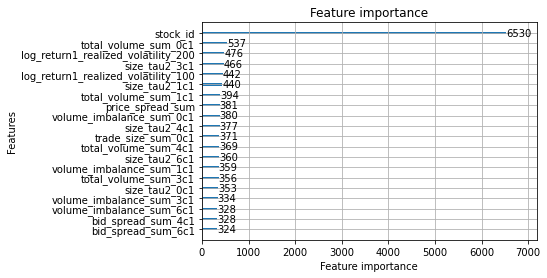

In [16]:
from sklearn.model_selection import KFold
import lightgbm as lgb

seed0=2021
params0 = {
    'objective': 'rmse',
    'boosting_type': 'gbdt',
    'max_depth': -1,
    'max_bin':100,
    'min_data_in_leaf':500,
    'learning_rate': 0.05,
    'subsample': 0.72,
    'subsample_freq': 4,
    'feature_fraction': 0.5,
    'lambda_l1': 0.5,
    'lambda_l2': 1.0,
    'categorical_column':[0],
    'seed':seed0,
    'feature_fraction_seed': seed0,
    'bagging_seed': seed0,
    'drop_seed': seed0,
    'data_random_seed': seed0,
    'n_jobs':-1,
    'verbose': -1}
seed1=42
params1 = {
        'learning_rate': 0.1,        
        'lambda_l1': 2,
        'lambda_l2': 7,
        'num_leaves': 800,
        'min_sum_hessian_in_leaf': 20,
        'feature_fraction': 0.8,
        'feature_fraction_bynode': 0.8,
        'bagging_fraction': 0.9,
        'bagging_freq': 42,
        'min_data_in_leaf': 700,
        'max_depth': 4,
        'categorical_column':[0],
        'seed': seed1,
        'feature_fraction_seed': seed1,
        'bagging_seed': seed1,
        'drop_seed': seed1,
        'data_random_seed': seed1,
        'objective': 'rmse',
        'boosting': 'gbdt',
        'verbosity': -1,
        'n_jobs':-1,
    }
# Function to early stop with root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False

def train_and_evaluate_lgb(train, test, params):
    # Hyperparammeters (just basic)
    
    features = [col for col in train.columns if col not in {"time_id", "target", "row_id"}]
    y = train['target']
    # Create out of folds array
    oof_predictions = np.zeros(train.shape[0])
    # Create test array to store predictions
    test_predictions = np.zeros(test.shape[0])
    # Create a KFold object
    kfold = KFold(n_splits = 5, random_state = 2021, shuffle = True)
    # Iterate through each fold
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(train)):
        print(f'Training fold {fold + 1}')
        x_train, x_val = train.iloc[trn_ind], train.iloc[val_ind]
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        # Root mean squared percentage error weights
        train_weights = 1 / np.square(y_train)
        val_weights = 1 / np.square(y_val)
        train_dataset = lgb.Dataset(x_train[features], y_train, weight = train_weights)
        val_dataset = lgb.Dataset(x_val[features], y_val, weight = val_weights)
        model = lgb.train(params = params,
                          num_boost_round=1400,
                          train_set = train_dataset, 
                          valid_sets = [train_dataset, val_dataset], 
                          verbose_eval = 250,
                          early_stopping_rounds=50,
                          feval = feval_rmspe)
        # Add predictions to the out of folds array
        oof_predictions[val_ind] = model.predict(x_val[features])
        # Predict the test set
        test_predictions += model.predict(test[features]) / 5
    rmspe_score = rmspe(y, oof_predictions)
    print(f'Our out of folds RMSPE is {rmspe_score}')
    lgb.plot_importance(model,max_num_features=20)
    # Return test predictions
    return test_predictions
# Traing and evaluate
predictions_lgb1= train_and_evaluate_lgb(train, test,params0)
#test['target'] = predictions_lgb
#test[['row_id', 'target']].to_csv('submission.csv',index = False)

Training fold 1
Training until validation scores don't improve for 50 rounds
[250]	training's rmse: 0.000428118	training's RMSPE: 0.19821	valid_1's rmse: 0.000446478	valid_1's RMSPE: 0.206339
[500]	training's rmse: 0.000406289	training's RMSPE: 0.188103	valid_1's rmse: 0.000432274	valid_1's RMSPE: 0.199774
[750]	training's rmse: 0.000392293	training's RMSPE: 0.181624	valid_1's rmse: 0.000424188	valid_1's RMSPE: 0.196037
[1000]	training's rmse: 0.000382443	training's RMSPE: 0.177063	valid_1's rmse: 0.000420078	valid_1's RMSPE: 0.194138
[1250]	training's rmse: 0.000374347	training's RMSPE: 0.173315	valid_1's rmse: 0.000417374	valid_1's RMSPE: 0.192888
[1500]	training's rmse: 0.000367493	training's RMSPE: 0.170141	valid_1's rmse: 0.000415488	valid_1's RMSPE: 0.192017
Did not meet early stopping. Best iteration is:
[1500]	training's rmse: 0.000367493	training's RMSPE: 0.170141	valid_1's rmse: 0.000415488	valid_1's RMSPE: 0.192017
Training fold 2
Training until validation scores don't impro

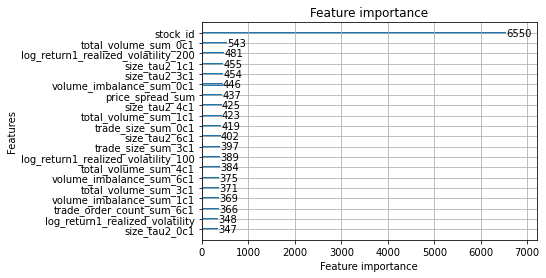

In [17]:
from sklearn.model_selection import KFold
import lightgbm as lgb

seed0=1111
params111 = {
    'objective': 'rmse',
    'boosting_type': 'gbdt',
    'max_depth': -1,
    'max_bin':100,
    'min_data_in_leaf':500,
    'learning_rate': 0.05,
    'subsample': 0.72,
    'subsample_freq': 4,
    'feature_fraction': 0.5,
    'lambda_l1': 0.5,
    'lambda_l2': 1.0,
    'categorical_column':[0],
    'seed':seed0,
    'feature_fraction_seed': seed0,
    'bagging_seed': seed0,
    'drop_seed': seed0,
    'data_random_seed': seed0,
    'n_jobs':-1,
    'verbose': -1}
seed1=42
params1 = {
        'learning_rate': 0.1,        
        'lambda_l1': 2,
        'lambda_l2': 7,
        'num_leaves': 800,
        'min_sum_hessian_in_leaf': 20,
        'feature_fraction': 0.8,
        'feature_fraction_bynode': 0.8,
        'bagging_fraction': 0.9,
        'bagging_freq': 42,
        'min_data_in_leaf': 700,
        'max_depth': 4,
        'categorical_column':[0],
        'seed': seed1,
        'feature_fraction_seed': seed1,
        'bagging_seed': seed1,
        'drop_seed': seed1,
        'data_random_seed': seed1,
        'objective': 'rmse',
        'boosting': 'gbdt',
        'verbosity': -1,
        'n_jobs':-1,
    }
# Function to early stop with root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False

def train_and_evaluate_lgb(train, test, params):
    # Hyperparammeters (just basic)
    
    features = [col for col in train.columns if col not in {"time_id", "target", "row_id"}]
    y = train['target']
    # Create out of folds array
    oof_predictions = np.zeros(train.shape[0])
    # Create test array to store predictions
    test_predictions = np.zeros(test.shape[0])
    # Create a KFold object
    kfold = KFold(n_splits = 5, random_state = 1111, shuffle = True)
    # Iterate through each fold
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(train)):
        print(f'Training fold {fold + 1}')
        x_train, x_val = train.iloc[trn_ind], train.iloc[val_ind]
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        # Root mean squared percentage error weights
        train_weights = 1 / np.square(y_train)
        val_weights = 1 / np.square(y_val)
        train_dataset = lgb.Dataset(x_train[features], y_train, weight = train_weights)
        val_dataset = lgb.Dataset(x_val[features], y_val, weight = val_weights)
        model = lgb.train(params = params,
                          num_boost_round=1500,
                          train_set = train_dataset, 
                          valid_sets = [train_dataset, val_dataset], 
                          verbose_eval = 250,
                          early_stopping_rounds=50,
                          feval = feval_rmspe)
        # Add predictions to the out of folds array
        oof_predictions[val_ind] = model.predict(x_val[features])
        # Predict the test set
        test_predictions += model.predict(test[features]) / 5
    rmspe_score = rmspe(y, oof_predictions)
    print(f'Our out of folds RMSPE is {rmspe_score}')
    lgb.plot_importance(model,max_num_features=20)
    # Return test predictions
    return test_predictions
# Traing and evaluate
predictions_lgb2= train_and_evaluate_lgb(train, test,params111)
#test['target'] = predictions_lgb
#test[['row_id', 'target']].to_csv('submission.csv',index = False)

In [18]:
predictions_lgb1,predictions_lgb2

(array([0.00187833, 0.0020438 , 0.0020438 ]),
 array([0.001803  , 0.00201663, 0.00201663]))

In [19]:
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor

# Function to early stop with root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False

def train_and_evaluate_cat(train, test):
    FOLD = 5
    SEEDS = [11]

    fet_imp = 0
    counter = 0
    oof_score = 0
    y_pred_meta_cb = np.zeros((train.shape[0], 1))
    y_pred_final_cb = 0
    cat_cols_indices = [train.columns.get_loc('stock_id')]
    features = [col for col in train.columns if col not in {"time_id", "target", "row_id"}]
    
    Xtrain = train[features].copy()
    Ytrain = train['target'].copy()
    Xtest = test[features].copy()


    for sidx, seed in enumerate(SEEDS):
        seed_score = 0
    
        kfold = KFold(n_splits=FOLD, shuffle=True, random_state=seed)

        for idx, (vtrain, val) in enumerate(kfold.split(train)):
            counter += 1
        
            train_x, train_y = Xtrain.iloc[vtrain], Ytrain.iloc[vtrain]
            val_x, val_y = Xtrain.iloc[val], Ytrain.iloc[val]
            sample_weight = 1/np.square(train_y)
        
            model = CatBoostRegressor(
                objective='RMSE',
                eval_metric='RMSE',
                num_boost_round=1500,
                #max_ctr_complexity=15,
                #od_wait=500, 
                od_type='Iter',
                learning_rate=0.05, # 0.05
                #reg_lambda=0.05,
                bootstrap_type='Bernoulli',
                use_best_model=True, 
                #subsample=0.8,
                grow_policy='Lossguide',
                #min_data_in_leaf=500, 
                #task_type='GPU',
                random_state=21 # 0
                )

            model.fit(train_x, train_y, eval_set=[(val_x, val_y)], 
                    cat_features=cat_cols_indices, 
                    sample_weight=sample_weight, 
                    early_stopping_rounds=100, verbose=250)

            y_pred = model.predict(val_x)
            y_pred_meta_cb[val] += np.array([y_pred]).T
            y_pred_final_cb += model.predict(Xtest)
        
            score = rmspe(val_y, y_pred)
            oof_score += score
            seed_score += score
            fet_imp += model.feature_importances_
            print("\nSeed-{} | Fold-{} | OOF Score: {}\n".format(seed, idx, score))
        
            #joblib.dump(model, f'./cb_model_{idx + 1}C.txt')
    
        print("\nSeed: {} | Aggregate OOF Score: {}\n\n".format(seed, (seed_score / FOLD)))


    y_pred_meta_cb = y_pred_meta_cb / float(len(SEEDS))
    y_pred_final_cb = y_pred_final_cb / float(counter)
    fet_imp = fet_imp / float(counter)
    oof_score /= float(counter)
    print("Aggregate OOF Score: {}".format(oof_score))

    del Xtrain, Ytrain, Xtest
    gc.collect()
    return y_pred_final_cb
# Traing and evaluate
predictions_cat = train_and_evaluate_cat(train, test)

0:	learn: 0.0011699	test: 0.0035249	best: 0.0035249 (0)	total: 992ms	remaining: 24m 46s
250:	learn: 0.0005299	test: 0.0016338	best: 0.0016337 (249)	total: 3m 17s	remaining: 16m 22s
500:	learn: 0.0004497	test: 0.0011939	best: 0.0011939 (500)	total: 6m 52s	remaining: 13m 42s
750:	learn: 0.0004218	test: 0.0011289	best: 0.0011289 (750)	total: 10m 31s	remaining: 10m 29s
1000:	learn: 0.0004066	test: 0.0010971	best: 0.0010971 (1000)	total: 14m 8s	remaining: 7m 2s
1250:	learn: 0.0003960	test: 0.0010772	best: 0.0010772 (1250)	total: 17m 43s	remaining: 3m 31s
1499:	learn: 0.0003881	test: 0.0010640	best: 0.0010640 (1499)	total: 21m 17s	remaining: 0us

bestTest = 0.00106397878
bestIteration = 1499


Seed-11 | Fold-0 | OOF Score: 0.19740093543553766

0:	learn: 0.0011686	test: 0.0035331	best: 0.0035331 (0)	total: 828ms	remaining: 20m 40s
250:	learn: 0.0005233	test: 0.0016035	best: 0.0016035 (250)	total: 3m 16s	remaining: 16m 18s
500:	learn: 0.0004493	test: 0.0012159	best: 0.0012159 (500)	total: 6m 5

In [20]:
predictions_cat

array([0.00419398, 0.0047687 , 0.0047687 ])

In [21]:
"""
def train_and_evaluate_lgb(train, test):
    FOLD = 5
    SEEDS = [1111]

    fet_imp = 0
    counter = 0
    oof_score = 0
    y_pred_meta_lgb = np.zeros((train.shape[0], 1))
    y_pred_final_lgb = 0
    cat_cols_indices = [train.columns.get_loc('stock_id')]
    features = [col for col in train.columns if col not in {"time_id", "target", "row_id"}]
    
    Xtrain = train[features].copy()
    Ytrain = train['target'].copy()
    Xtest = test[features].copy()


    for sidx, seed in enumerate(SEEDS):
        seed_score = 0
    
        kfold = KFold(n_splits=FOLD, shuffle=True, random_state=seed)

        for idx, (vtrain, val) in enumerate(kfold.split(train)):
            counter += 1
        
            train_x, train_y = Xtrain.iloc[vtrain], Ytrain.iloc[vtrain]
            val_x, val_y = Xtrain.iloc[val], Ytrain.iloc[val]
            sample_weight = 1/np.square(train_y)
        
            model = LGBMRegressor(
            boosting_type='gbdt', 
            num_leaves=175, 
            max_depth=9, 
            learning_rate=0.05, 
            n_estimators=1500,
            objective='regression', 
            #importance_type='gain',
            #device='gpu',
            #max_bin=100,
            #min_child_samples=500, 
            subsample=0.85, 
            subsample_freq=5, 
            colsample_bytree=0.55, 
            reg_lambda=0.05,
            random_state=1111,
            bagging_seed=0,
            feature_fraction_seed=0
        )
        
            model.fit(train_x, train_y, eval_metric='rmse',
                    eval_set=[(train_x, train_y), (val_x, val_y)],
                      early_stopping_rounds=100, verbose=500,
                      categorical_feature=cat_cols_indices,
                      sample_weight=sample_weight)

            y_pred = model.predict(val_x, num_iteration=model.best_iteration_)
            y_pred_meta_lgb[val] += np.array([y_pred]).T
            y_pred_final_lgb += model.predict(Xtest, num_iteration=model.best_iteration_)
        
            score = rmspe(val_y, y_pred)
            oof_score += score
            seed_score += score
            fet_imp += model.feature_importances_
            print("\nSeed-{} | Fold-{} | OOF Score: {}\n".format(seed, idx, score))
        
            joblib.dump(model, f'./lgb_model_{idx + 1}C.txt')
    
        print("\nSeed: {} | Aggregate OOF Score: {}\n\n".format(seed, (seed_score / FOLD)))


    y_pred_meta_lgb = y_pred_meta_lgb / float(len(SEEDS))
    y_pred_final_lgb = y_pred_final_lgb / float(counter)
    fet_imp = fet_imp / float(counter)
    oof_score /= float(counter)
    print("Aggregate OOF Score: {}".format(oof_score))
    del Xtrain, Ytrain, Xtest
    gc.collect()
    return y_pred_final_lgb
    
predictions_lgb = train_and_evaluate_lgb(train, test)
"""

'\ndef train_and_evaluate_lgb(train, test):\n    FOLD = 5\n    SEEDS = [1111]\n\n    fet_imp = 0\n    counter = 0\n    oof_score = 0\n    y_pred_meta_lgb = np.zeros((train.shape[0], 1))\n    y_pred_final_lgb = 0\n    cat_cols_indices = [train.columns.get_loc(\'stock_id\')]\n    features = [col for col in train.columns if col not in {"time_id", "target", "row_id"}]\n    \n    Xtrain = train[features].copy()\n    Ytrain = train[\'target\'].copy()\n    Xtest = test[features].copy()\n\n\n    for sidx, seed in enumerate(SEEDS):\n        seed_score = 0\n    \n        kfold = KFold(n_splits=FOLD, shuffle=True, random_state=seed)\n\n        for idx, (vtrain, val) in enumerate(kfold.split(train)):\n            counter += 1\n        \n            train_x, train_y = Xtrain.iloc[vtrain], Ytrain.iloc[vtrain]\n            val_x, val_y = Xtrain.iloc[val], Ytrain.iloc[val]\n            sample_weight = 1/np.square(train_y)\n        \n            model = LGBMRegressor(\n            boosting_type=\'gbdt\

In [22]:
#predictions_lgb

In [23]:
from numpy.random import seed
seed(42)
import tensorflow as tf
tf.random.set_seed(42)
from tensorflow import keras
import numpy as np
from keras import backend as K
def root_mean_squared_per_error(y_true, y_pred):
         return K.sqrt(K.mean(K.square( (y_true - y_pred)/ y_true )))
    
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, verbose=0,
    mode='min',restore_best_weights=True)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=7, verbose=0,
    mode='min')

In [24]:
# kfold based on the knn++ algorithm

out_train = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
out_train = out_train.pivot(index='time_id', columns='stock_id', values='target')

#out_train[out_train.isna().any(axis=1)]
out_train = out_train.fillna(out_train.mean())
out_train.head()

# code to add the just the read data after first execution

# data separation based on knn ++
nfolds = 5 # number of folds
index = []
totDist = []
values = []
# generates a matriz with the values of 
mat = out_train.values

scaler = MinMaxScaler(feature_range=(-1, 1))
mat = scaler.fit_transform(mat)

nind = int(mat.shape[0]/nfolds) # number of individuals

# adds index in the last column
mat = np.c_[mat,np.arange(mat.shape[0])]


lineNumber = np.random.choice(np.array(mat.shape[0]), size=nfolds, replace=False)

lineNumber = np.sort(lineNumber)[::-1]

for n in range(nfolds):
    totDist.append(np.zeros(mat.shape[0]-nfolds))

# saves index
for n in range(nfolds):
    
    values.append([lineNumber[n]])    


s=[]
for n in range(nfolds):
    s.append(mat[lineNumber[n],:])
    
    mat = np.delete(mat, obj=lineNumber[n], axis=0)

for n in range(nind-1):    

    luck = np.random.uniform(0,1,nfolds)
    
    for cycle in range(nfolds):
         # saves the values of index           

        s[cycle] = np.matlib.repmat(s[cycle], mat.shape[0], 1)

        sumDist = np.sum( (mat[:,:-1] - s[cycle][:,:-1])**2 , axis=1)   
        totDist[cycle] += sumDist        
                
        # probabilities
        f = totDist[cycle]/np.sum(totDist[cycle]) # normalizing the totdist
        j = 0
        kn = 0
        for val in f:
            j += val        
            if (j > luck[cycle]): # the column was selected
                break
            kn +=1
        lineNumber[cycle] = kn
        
        # delete line of the value added    
        for n_iter in range(nfolds):
            
            totDist[n_iter] = np.delete(totDist[n_iter],obj=lineNumber[cycle], axis=0)
            j= 0
        
        s[cycle] = mat[lineNumber[cycle],:]
        values[cycle].append(int(mat[lineNumber[cycle],-1]))
        mat = np.delete(mat, obj=lineNumber[cycle], axis=0)


for n_mod in range(nfolds):
    values[n_mod] = out_train.index[values[n_mod]]

In [25]:
#colNames.remove('row_id')
train.replace([np.inf, -np.inf], np.nan,inplace=True)
test.replace([np.inf, -np.inf], np.nan,inplace=True)
qt_train = []
train_nn=train[colNames].copy()
test_nn=test[colNames].copy()
for col in colNames:
    #print(col)
    qt = QuantileTransformer(random_state=1111,n_quantiles=2000, output_distribution='normal')
    train_nn[col] = qt.fit_transform(train_nn[[col]])
    test_nn[col] = qt.transform(test_nn[[col]])    
    qt_train.append(qt)

In [26]:
train_nn[['stock_id','time_id','target']]=train[['stock_id','time_id','target']]
test_nn[['stock_id','time_id']]=test[['stock_id','time_id']]

In [27]:
# making agg features
from sklearn.cluster import KMeans
train_p = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
train_p = train_p.pivot(index='time_id', columns='stock_id', values='target')

corr = train_p.corr()#method = 'pearson' 'kendall' 'spearman'

ids = corr.index

kmeans = KMeans(n_clusters=7, random_state=0).fit(corr.values)
print(kmeans.labels_)

l = []
for n in range(7):
    l.append ( [ (x-1) for x in ( (ids+1)*(kmeans.labels_ == n)) if x > 0] )
    

mat = []
matTest = []

n = 0
for ind in l:
    print(ind)
    newDf = train_nn.loc[train_nn['stock_id'].isin(ind) ]
    newDf = newDf.groupby(['time_id']).agg(np.nanmean)
    newDf.loc[:,'stock_id'] = str(n)+'c1'
    mat.append ( newDf )
    
    newDf = test_nn.loc[test_nn['stock_id'].isin(ind) ]    
    newDf = newDf.groupby(['time_id']).agg(np.nanmean)
    newDf.loc[:,'stock_id'] = str(n)+'c1'
    matTest.append ( newDf )
    
    n+=1
    
mat1 = pd.concat(mat).reset_index()
mat1.drop(columns=['target'],inplace=True)

mat2 = pd.concat(matTest).reset_index()
mat2 = pd.concat([mat2,mat1.loc[mat1.time_id==5]])

[1 0 4 2 1 1 2 4 6 2 1 0 4 4 1 1 1 2 4 4 4 0 1 1 3 1 1 4 3 4 3 4 4 1 3 3 4
 3 4 1 4 1 4 4 1 0 4 4 1 0 0 3 3 3 2 0 2 4 1 4 4 1 4 1 0 3 3 0 3 0 6 5 3 3
 0 1 2 0 3 3 3 4 1 1 0 2 3 3 1 0 1 4 4 4 4 4 1 3 1 0 1 4 1 0 1 4 1 0 4 0 4
 0]
[1, 11, 22, 50, 55, 56, 62, 73, 76, 78, 84, 87, 96, 101, 112, 116, 122, 124, 126]
[0, 4, 5, 10, 15, 16, 17, 23, 26, 28, 29, 36, 42, 44, 48, 53, 66, 69, 72, 85, 94, 95, 100, 102, 109, 111, 113, 115, 118, 120]
[3, 6, 9, 18, 61, 63, 86, 97]
[27, 31, 33, 37, 38, 40, 58, 59, 60, 74, 75, 77, 82, 83, 88, 89, 90, 98, 99, 110]
[2, 7, 13, 14, 19, 20, 21, 30, 32, 34, 35, 39, 41, 43, 46, 47, 51, 52, 64, 67, 68, 70, 93, 103, 104, 105, 107, 108, 114, 119, 123, 125]
[81]
[8, 80]


In [28]:
nnn = ['time_id',
     'log_return1_realized_volatility_0c1',
     'log_return1_realized_volatility_1c1',     
     'log_return1_realized_volatility_3c1',
     'log_return1_realized_volatility_4c1',     
     'log_return1_realized_volatility_6c1',
     'total_volume_sum_0c1',
     'total_volume_sum_1c1', 
     'total_volume_sum_3c1',
     'total_volume_sum_4c1', 
     'total_volume_sum_6c1',
     'trade_size_sum_0c1',
     'trade_size_sum_1c1', 
     'trade_size_sum_3c1',
     'trade_size_sum_4c1', 
     'trade_size_sum_6c1',
     'trade_order_count_sum_0c1',
     'trade_order_count_sum_1c1',
     'trade_order_count_sum_3c1',
     'trade_order_count_sum_4c1',
     'trade_order_count_sum_6c1',      
     'price_spread_sum_0c1',
     'price_spread_sum_1c1',
     'price_spread_sum_3c1',
     'price_spread_sum_4c1',
     'price_spread_sum_6c1',   
     'bid_spread_sum_0c1',
     'bid_spread_sum_1c1',
     'bid_spread_sum_3c1',
     'bid_spread_sum_4c1',
     'bid_spread_sum_6c1',       
     'ask_spread_sum_0c1',
     'ask_spread_sum_1c1',
     'ask_spread_sum_3c1',
     'ask_spread_sum_4c1',
     'ask_spread_sum_6c1',   
     'volume_imbalance_sum_0c1',
     'volume_imbalance_sum_1c1',
     'volume_imbalance_sum_3c1',
     'volume_imbalance_sum_4c1',
     'volume_imbalance_sum_6c1',       
     'bid_ask_spread_sum_0c1',
     'bid_ask_spread_sum_1c1',
     'bid_ask_spread_sum_3c1',
     'bid_ask_spread_sum_4c1',
     'bid_ask_spread_sum_6c1',
     'size_tau2_0c1',
     'size_tau2_1c1',
     'size_tau2_3c1',
     'size_tau2_4c1',
     'size_tau2_6c1',]
     #'relative_wap_balance1_sum_0c1',
     #'relative_wap_balance1_sum_1c1',
     #'relative_wap_balance1_sum_3c1',
     #'relative_wap_balance1_sum_4c1',
     #'relative_wap_balance1_sum_6c1',]


In [29]:
mat1 = mat1.pivot(index='time_id', columns='stock_id')
mat1.columns = ["_".join(x) for x in mat1.columns.ravel()]
mat1.reset_index(inplace=True)

mat2 = mat2.pivot(index='time_id', columns='stock_id')
mat2.columns = ["_".join(x) for x in mat2.columns.ravel()]
mat2.reset_index(inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  


In [30]:
import gc
train_nn = pd.merge(train_nn,mat1[nnn],how='left',on='time_id')
test_nn = pd.merge(test_nn,mat2[nnn],how='left',on='time_id')

train1=train_nn
test1=test_nn
del mat1,mat2
del train,test
gc.collect()

0

In [31]:
#https://bignerdranch.com/blog/implementing-swish-activation-function-in-keras/
from keras.backend import sigmoid
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
get_custom_objects().update({'swish': Activation(swish)})

hidden_units = (128,64,32)
stock_embedding_size = 24

cat_data = train_nn['stock_id']

def base_model():
    
    # Each instance will consist of two inputs: a single user id, and a single movie id
    stock_id_input = keras.Input(shape=(1,), name='stock_id')
    num_input = keras.Input(shape=(284,), name='num_data')


    #embedding, flatenning and concatenating
    stock_embedded = keras.layers.Embedding(max(cat_data)+1, stock_embedding_size, 
                                           input_length=1, name='stock_embedding')(stock_id_input)
    stock_flattened = keras.layers.Flatten()(stock_embedded)
    out = keras.layers.Concatenate()([stock_flattened, num_input])
    
    # Add one or more hidden layers
    for n_hidden in hidden_units:

        out = keras.layers.Dense(n_hidden, activation='swish')(out)
        

    #out = keras.layers.Concatenate()([out, num_input])

    # A single output: our predicted rating
    out = keras.layers.Dense(1, activation='linear', name='prediction')(out)
    
    model = keras.Model(
    inputs = [stock_id_input, num_input],
    outputs = out,
    )
    
    return model

In [32]:
# Function to calculate the root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

# Function to early stop with root mean squared percentage error
def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False

In [33]:
target_name='target'
scores_folds = {}
model_name = 'NN'
pred_name = 'pred_{}'.format(model_name)

n_folds = 5
kf = model_selection.KFold(n_splits=n_folds, shuffle=True, random_state=2020)
scores_folds[model_name] = []
counter = 1

features_to_consider = list(train_nn)

features_to_consider.remove('time_id')
features_to_consider.remove('target')
try:
    features_to_consider.remove('pred_NN')
except:
    pass


train_nn[features_to_consider] = train_nn[features_to_consider].fillna(train_nn[features_to_consider].mean())
test_nn[features_to_consider] = test_nn[features_to_consider].fillna(train_nn[features_to_consider].mean())

train_nn[pred_name] = 0
test_nn[target_name] = 0
test_predictions_nn = np.zeros(test_nn.shape[0])

for n_count in range(n_folds):
    print('CV {}/{}'.format(counter, n_folds))
    
    indexes = np.arange(nfolds).astype(int)    
    indexes = np.delete(indexes,obj=n_count, axis=0) 
    
    indexes = np.r_[values[indexes[0]],values[indexes[1]],values[indexes[2]],values[indexes[3]]]
    
    X_train = train_nn.loc[train_nn.time_id.isin(indexes), features_to_consider]
    y_train = train_nn.loc[train_nn.time_id.isin(indexes), target_name]
    X_test = train_nn.loc[train_nn.time_id.isin(values[n_count]), features_to_consider]
    y_test = train_nn.loc[train_nn.time_id.isin(values[n_count]), target_name]
    
    #############################################################################################
    # NN
    #############################################################################################
    
    model = base_model()
    
    model.compile(
        keras.optimizers.Adam(learning_rate=0.006),
        loss=root_mean_squared_per_error
    )
    
    try:
        features_to_consider.remove('stock_id')
    except:
        pass
    
    num_data = X_train[features_to_consider]
    
    scaler = MinMaxScaler(feature_range=(-1, 1))         
    num_data = scaler.fit_transform(num_data.values)    
    
    cat_data = X_train['stock_id']    
    target =  y_train
    
    num_data_test = X_test[features_to_consider]
    num_data_test = scaler.transform(num_data_test.values)
    cat_data_test = X_test['stock_id']

    model.fit([cat_data, num_data], 
              target,               
              batch_size=2048,
              epochs=1000,
              validation_data=([cat_data_test, num_data_test], y_test),
              callbacks=[es, plateau],
              validation_batch_size=len(y_test),
              shuffle=True,
             verbose = 1)

    preds = model.predict([cat_data_test, num_data_test]).reshape(1,-1)[0]
    
    score = round(rmspe(y_true = y_test, y_pred = preds),5)
    print('Fold {} {}: {}'.format(counter, model_name, score))
    scores_folds[model_name].append(score)
    
    tt =scaler.transform(test_nn[features_to_consider].values)
    #test_nn[target_name] += model.predict([test_nn['stock_id'], tt]).reshape(1,-1)[0].clip(0,1e10)
    test_predictions_nn += model.predict([test_nn['stock_id'], tt]).reshape(1,-1)[0].clip(0,1e10)/n_folds
    #test[target_name] += model.predict([test['stock_id'], test[features_to_consider]]).reshape(1,-1)[0].clip(0,1e10)
       
    counter += 1
    features_to_consider.append('stock_id')

CV 1/5
Epoch 1/1000
168/168 [==============================] - 4s 19ms/step - loss: 24.6384 - val_loss: 1.2070
Epoch 2/1000
168/168 [==============================] - 2s 13ms/step - loss: 0.8579 - val_loss: 0.5029
Epoch 3/1000
168/168 [==============================] - 2s 13ms/step - loss: 0.6502 - val_loss: 0.5070
Epoch 4/1000
168/168 [==============================] - 3s 15ms/step - loss: 0.6272 - val_loss: 0.7169
Epoch 5/1000
168/168 [==============================] - 2s 14ms/step - loss: 0.6451 - val_loss: 0.7006
Epoch 6/1000
168/168 [==============================] - 2s 13ms/step - loss: 0.5770 - val_loss: 0.4881
Epoch 7/1000
168/168 [==============================] - 2s 13ms/step - loss: 0.5742 - val_loss: 0.4307
Epoch 8/1000
168/168 [==============================] - 2s 14ms/step - loss: 0.5758 - val_loss: 0.4771
Epoch 9/1000
168/168 [==============================] - 2s 14ms/step - loss: 0.3314 - val_loss: 0.2645
Epoch 10/1000
168/168 [==============================] - 2s 14ms/

In [34]:
test_predictions_nn

array([0.00177634, 0.00269826, 0.00269826])

In [35]:
from numpy.random import seed
seed(41)
import tensorflow as tf
tf.random.set_seed(41)
from tensorflow import keras

target_name='target'
scores_folds = {}
model_name = 'NN'
pred_name = 'pred_{}'.format(model_name)

n_folds = 5
kf = model_selection.KFold(n_splits=n_folds, shuffle=True, random_state=2021)
scores_folds[model_name] = []
counter = 1

features_to_consider = list(train1)

features_to_consider.remove('time_id')
features_to_consider.remove('target')
try:
    features_to_consider.remove('pred_NN')
except:
    pass


train1[features_to_consider] = train1[features_to_consider].fillna(train1[features_to_consider].mean())
test1[features_to_consider] = test1[features_to_consider].fillna(train1[features_to_consider].mean())

train1[pred_name] = 0
test1[target_name] = 0
test_predictions_nn1 = np.zeros(test_nn.shape[0])

for n_count in range(n_folds):
    print('CV {}/{}'.format(counter, n_folds))
    
    indexes = np.arange(nfolds).astype(int)    
    indexes = np.delete(indexes,obj=n_count, axis=0) 
    
    indexes = np.r_[values[indexes[0]],values[indexes[1]],values[indexes[2]],values[indexes[3]]]
    
    X_train = train1.loc[train1.time_id.isin(indexes), features_to_consider]
    y_train = train1.loc[train1.time_id.isin(indexes), target_name]
    X_test = train1.loc[train1.time_id.isin(values[n_count]), features_to_consider]
    y_test = train1.loc[train1.time_id.isin(values[n_count]), target_name]
    
    #############################################################################################
    # NN
    #############################################################################################
    
    model = base_model()
    
    model.compile(
        keras.optimizers.Adam(learning_rate=0.006),
        loss=root_mean_squared_per_error
    )
    
    try:
        features_to_consider.remove('stock_id')
    except:
        pass
    
    num_data = X_train[features_to_consider]
    
    scaler = MinMaxScaler(feature_range=(-1, 1))         
    num_data = scaler.fit_transform(num_data.values)    
    
    cat_data = X_train['stock_id']    
    target =  y_train
    
    num_data_test = X_test[features_to_consider]
    num_data_test = scaler.transform(num_data_test.values)
    cat_data_test = X_test['stock_id']

    model.fit([cat_data, num_data], 
              target,               
              batch_size=2048,
              epochs=1000,
              validation_data=([cat_data_test, num_data_test], y_test),
              callbacks=[es, plateau],
              validation_batch_size=len(y_test),
              shuffle=True,
             verbose = 1)

    preds = model.predict([cat_data_test, num_data_test]).reshape(1,-1)[0]
    
    score = round(rmspe(y_true = y_test, y_pred = preds),5)
    print('Fold {} {}: {}'.format(counter, model_name, score))
    scores_folds[model_name].append(score)
    
    tt =scaler.transform(test_nn[features_to_consider].values)
    #test_nn[target_name] += model.predict([test_nn['stock_id'], tt]).reshape(1,-1)[0].clip(0,1e10)
    test_predictions_nn1 += model.predict([test1['stock_id'], tt]).reshape(1,-1)[0].clip(0,1e10)/n_folds
    #test[target_name] += model.predict([test['stock_id'], test[features_to_consider]]).reshape(1,-1)[0].clip(0,1e10)
       
    counter += 1
    features_to_consider.append('stock_id')

CV 1/5
Epoch 1/1000
168/168 [==============================] - 3s 17ms/step - loss: 32.6265 - val_loss: 1.3429
Epoch 2/1000
168/168 [==============================] - 2s 14ms/step - loss: 0.7386 - val_loss: 0.5879
Epoch 3/1000
168/168 [==============================] - 2s 14ms/step - loss: 0.6285 - val_loss: 0.4744
Epoch 4/1000
168/168 [==============================] - 2s 14ms/step - loss: 0.5531 - val_loss: 0.5771
Epoch 5/1000
168/168 [==============================] - 2s 13ms/step - loss: 0.5392 - val_loss: 0.5602
Epoch 6/1000
168/168 [==============================] - 2s 13ms/step - loss: 0.5206 - val_loss: 0.6731
Epoch 7/1000
168/168 [==============================] - 2s 14ms/step - loss: 0.5078 - val_loss: 0.4789
Epoch 8/1000
168/168 [==============================] - 2s 14ms/step - loss: 0.4397 - val_loss: 0.7317
Epoch 9/1000
168/168 [==============================] - 2s 14ms/step - loss: 0.4904 - val_loss: 0.4816
Epoch 10/1000
168/168 [==============================] - 2s 14ms/

In [36]:
test1

,bid_price1_max,bid_price1_min,bid_price1_last,bid_price1_first,bid_price2_max,bid_price2_min,bid_price2_last,bid_price2_first,ask_price1_max,ask_price1_min,...,bid_ask_spread_sum_1c1,bid_ask_spread_sum_3c1,bid_ask_spread_sum_4c1,bid_ask_spread_sum_6c1,size_tau2_0c1,size_tau2_1c1,size_tau2_3c1,size_tau2_4c1,size_tau2_6c1,target
0,-0.725806,1.107053,0.111474,0.299485,-0.891856,0.948976,0.008407,0.052241,-0.615611,1.131312,...,-5.199337,0.032216,0.217304,0.427136,-0.084157,3.135875,0.593047,-0.158116,-0.479887,0
1,0.000041,-0.001605,-0.000537,0.001668,-0.000268,-0.001916,-0.000681,0.002108,0.000616,-0.000118,...,-0.218283,0.032216,0.217304,0.427136,-0.084157,-0.082936,0.593047,-0.158116,-0.479887,0
2,0.000041,-0.001605,-0.000537,0.001668,-0.000268,-0.001916,-0.000681,0.002108,0.000616,-0.000118,...,-0.218283,0.032216,0.217304,0.427136,-0.084157,-0.082936,0.593047,-0.158116,-0.479887,0


In [37]:
test=pd.read_csv("../input/optiver-realized-volatility-prediction/test.csv")
a=test_predictions_nn*0.6+predictions_lgb2*0.4 #0.6 0.4
b=test_predictions_nn1*0.6+predictions_lgb1*0.4 # 0.55 0.45
#test[target_name] = (a+b)/2
c=test_predictions_nn*0.6+predictions_cat*0.4
#d=test_predictions_nn1*0.56+predictions_lgb*0.44
test[target_name] = (a+b+c)/3

#test[target_name] = (test_predictions_nn*0.4+predictions_cat*0.3+predictions_lgb*0.3)/3

#a = test_predictions_nn*0.6+predictions_cat*0.4
#b = test_predictions_nn1*0.55+predictions_cat*0.45
#test[target_name] = (a+b)/2

display(test[['row_id', target_name]].head(3))
test[['row_id', target_name]].to_csv('submission.csv',index = False)
#test[['row_id', target_name]].to_csv('submission.csv',index = False)
#kmeans N=5 [0.2101, 0.21399, 0.20923, 0.21398, 0.21175]

,row_id,target
0,0-4,0.002477
1,0-32,0.002735
2,0-34,0.002735


references:

1. https://www.kaggle.com/shivansh002/hit-and-trial-2 